###Some points

- Test for case-control

- Test for de novo data

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

source("likelihoodFunctionCC.R")
source("TADAaddEvidence.R")
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes

# ASC (Autism Sequencing Consortium) data
# The file name contains the sample size information
# The only relevant counts are dn.LoF and dn.mis3
data <- read.csv("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data
N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)

# Running TADA
counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF, data$dn.mis3, data$case.mis3+data$trans.mis3,
 data$ctrl.mis3+data$ntrans.mis3))


count.mu.Data <- cbind(counts[, 1:3], data$mut.rate*mu.frac[1])
#Count.mu.Data <- cbind(counts[, 4:6], data$mut.rate*mu.frac[2])

########Calculate data.frame and likelihood function
##countData should be a data.frame including all annotation types.
#Each type includes 3 columns: de novo, case and control
                                        #mutData: a data.frame including mutation rates of each type

logLikelihood <- function(countData, hyperpar, pi0 = 0.06, mutationData,
                          testType = c("dn", "CaseControl", "both"), nCore = 1, combinationType = 1){
    ##Identify how many annotation types
    if (is.numeric(mutationData))
        mutationData <- cbind(mutationData)
    kk <- dim(mutationData)[2]

        ###Choose only de novo (dn), only cc (cc), or both ("both")
        testType <- match.arg(testType)

#    message("testType: ", testType)

    dataOut <- NULL

    logLLKallType <- 0

    for (jj in 1:kk){

        ##Extract each annotation
        sIndex <- 3*(jj - 1) + 1

        countData.type <- apply(cbind(countData[, c(sIndex, sIndex + 1, sIndex + 2)], mutationData[, jj]), 1, as.list)

#        print(dim(countData.type))

        typeData <- mclapply(countData.type, function(xRow){
                                 xRow <- as.numeric(xRow)
            x <- list(dn = xRow[1],
                    ca = xRow[2], cn = xRow[3], mu = xRow[4])

 #           print(xRow)
                #####Alternative hypothesis
                x.alt.CC <- evidence.alt.CC(x = x, N = N, gamma.mean = hyperpar[3, jj],
                                            beta = hyperpar[4, jj],
                                            rho1 = hyperpar[5, jj], nu1 = hyperpar[6, jj])$total

                x.alt.dn <- dnbinom(x = x$dn, hyperpar[1, jj]*hyperpar[2, jj],
                                   hyperpar[2, jj]/(hyperpar[2, jj] + 2*N$dn*x$mu))
                    #evidence.alt.dn(x = xRow[1], N = N$dn, mu = xRow[4],
                     #                       gamma.mean = hyperpar[1, 1], beta = hyperpar[2, 1])

#####Null hypothesis

                x.null.CC <- evidence.null.CC(x = x, N = N, rho0 = hyperpar[7, jj], nu0 = hyperpar[8, jj])$total
                x.null.dn <- dpois(x$dn, 2*N$dn*x$mu) #evidence.null.dn(x = xRow[1], N = N$dn, mu = xRow[4])


            return(c(x.alt.CC, x.alt.dn, x.null.CC, x.null.dn))

        }, mc.cores = nCore)

        #########Done

        ##############################################
                    ##########Calculate log likelihood
        typeData <- do.call(rbind, typeData)

            pH1.dn <- typeData[, 2]
            pH0.dn <- typeData[, 4]

        pH1.cc <- typeData[, 1]
        pH0.cc <- typeData[, 3]

        if (testType == "dn"){
            pH1 <- pi0*pH1.dn
            pH0 <- (1 - pi0)*pH0.dn
        }
        if (testType == "CaseControl"){
            pH1 <- pi0*pH1.cc
            pH0 <- (1 - pi0)*pH0.cc
        }

        if (testType == "both") {
            pH1 <- pi0*pH1.cc*pH1.dn
            pH0 <- (1- pi0)*pH0.cc*pH0.dn
        }
            pAll <- pH1 + pH0

            #sum(log(pAll))

            log.pAll <- sum(log(pAll[!is.na(pAll)]))#log(prod(pAll))


        dataOut <- cbind(dataOut, typeData)

            logLLKallType <- logLLKallType + log.pAll


    }


    return(list(dataOut = dataOut, logLik = logLLKallType))
}




In [10]:
%%R

mutationData <- data$mut.rate*mu.frac[1]
piFunc.dn.3 <- function(x){

    piX <- x[1]

    hyperparNew <- hyperpar
    hyperparNew[1, 1] <- x[2]
    hyperparNew[2, 1] <- x[3]

    log.All <- -logLikelihood(countData = counts, hyperpar = hyperparNew,
                                      pi0 = piX, mutationData = mutationData)$logLik
    return(log.All)
}


In [23]:
%%R

NN = 20
n.pi <- 15
n.gamma.mean.dn <- NN
n.beta.dn <- 10

s.pi <- sort(runif(n.pi, 0.01, 0.1))
s.gamma.mean.dn <- sort(runif(n.gamma.mean.dn, 1, 50))
s.beta.dn <- sort(runif(n.beta.dn, 1, 10))

dn.grid <- list()
inDex <- 1
for (ii in 1:n.pi){
    for (jj in 1:n.gamma.mean.dn){
        for (kk in 1:n.beta.dn){
            dn.grid[[inDex]] <- c(s.pi[ii], s.gamma.mean.dn[jj], s.beta.dn[kk])
        inDex <- inDex + 1
        }
    }
}

In [24]:
%%R
length(dn.grid)

[1] 3000


In [25]:
%%R
library("parallel")

#llk <- lapply(dn.grid, piFunc.dn.3)
llk <- mclapply(dn.grid, piFunc.dn.3)

In [26]:
%%R
llk0 <- as.numeric(llk)

In [27]:
%%R
c.grid <- cbind(do.call(rbind, dn.grid), llk0)

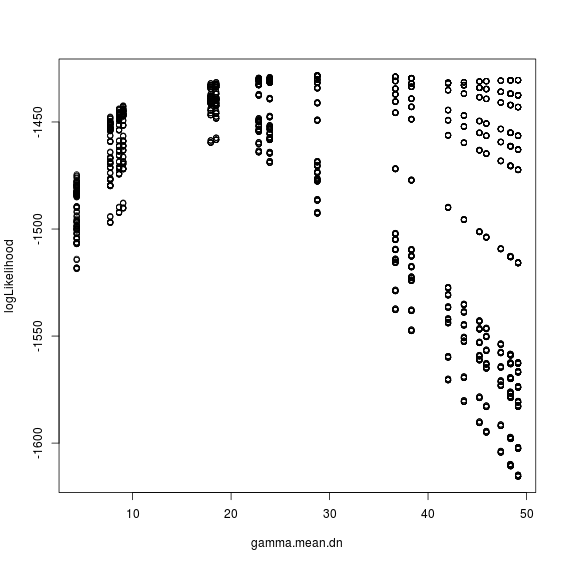

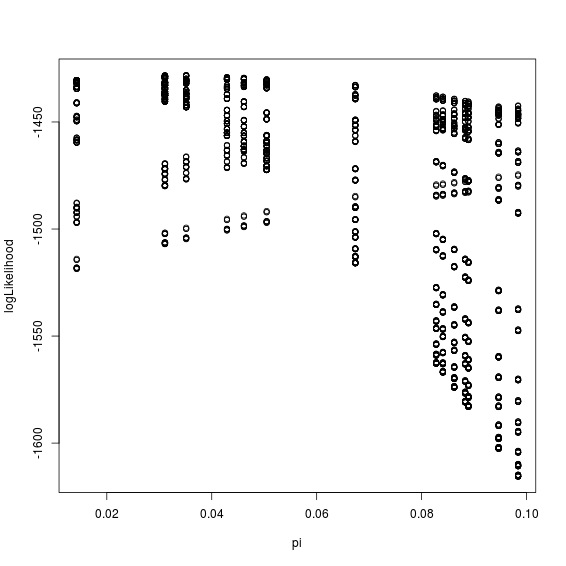

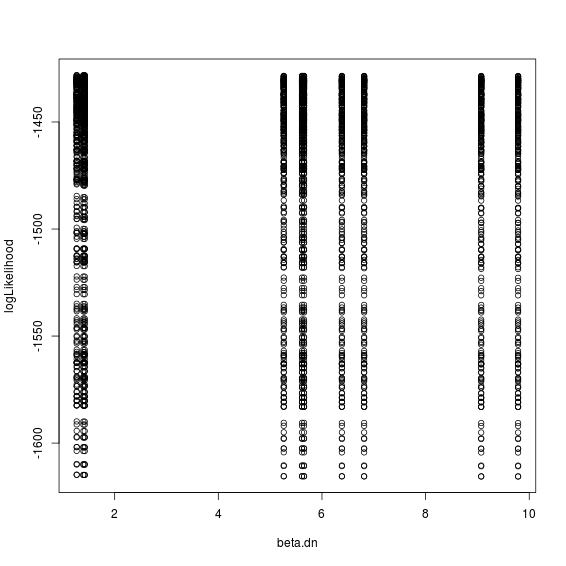

In [29]:
%%R -h 20 -w 20 -u cm

plot(c.grid[, 1], -c.grid[, 4], xlab = 'pi', ylab = 'logLikelihood')
plot(c.grid[, 2], -c.grid[, 4], xlab = 'gamma.mean.dn', ylab = 'logLikelihood')

plot(c.grid[, 3], -c.grid[, 4], xlab = 'beta.dn', ylab = 'logLikelihood')




In [30]:
%%R
head(c.grid)

                                      llk0
[1,] 0.01426122 4.321898 1.267117 1513.900
[2,] 0.01426122 4.321898 1.396600 1514.351
[3,] 0.01426122 4.321898 1.421962 1514.431
[4,] 0.01426122 4.321898 5.262705 1517.974
[5,] 0.01426122 4.321898 5.615052 1518.065
[6,] 0.01426122 4.321898 5.654172 1518.075


In [31]:
%%R
c.grid[which(c.grid[, 4] == min(c.grid[, 4])), ]

                                               llk0 
3.513024e-02 2.875564e+01 1.267117e+00 1.428079e+03 


In [32]:
%%R

mutationData <- data$mut.rate*mu.frac[1]
piFunc.cc.3 <- function(x){

    piX <- x[1]

    hyperparNew <- hyperpar
    hyperparNew[1, 1] <- x[2]
    hyperparNew[2, 1] <- x[3]

    log.All <- -logLikelihood(countData = counts, hyperpar = hyperparNew,
                                      pi0 = piX, mutationData = mutationData, testType = "CaseControl")$logLik
    return(log.All)
}



In [33]:
%%R

NN = 20
n.pi <- 15
n.gamma.mean.dn <- NN
n.beta.dn <- 10

s.pi <- sort(runif(n.pi, 0.01, 0.1))
s.gamma.mean.dn <- sort(runif(n.gamma.mean.dn, 1, 50))
s.beta.dn <- sort(runif(n.beta.dn, 1, 10))

cc.grid <- list()
inDex <- 1
for (ii in 1:n.pi){
    for (jj in 1:n.gamma.mean.dn){
        for (kk in 1:n.beta.dn){
            cc.grid[[inDex]] <- c(s.pi[ii], s.gamma.mean.dn[jj], s.beta.dn[kk])
        inDex <- inDex + 1
        }
    }
}

In [34]:
%%R
library("parallel")

#llk <- lapply(dn.grid, piFunc.dn.3)
cc.llk <- mclapply(cc.grid, piFunc.cc.3)

In [36]:
%%R
c.cc.grid <- cbind(do.call(rbind, cc.grid), as.numeric(cc.llk))

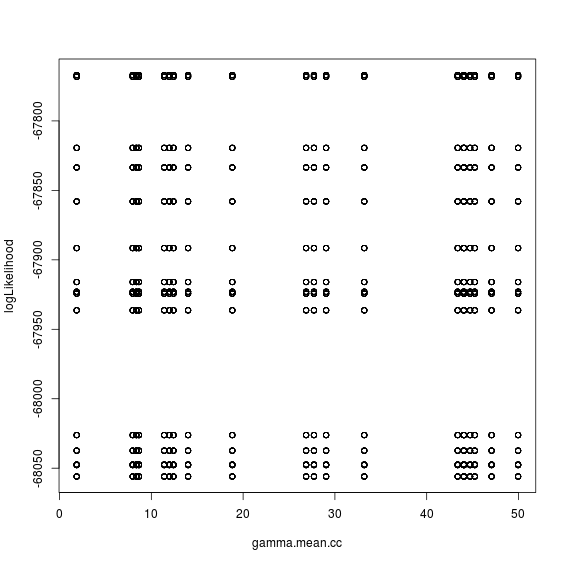

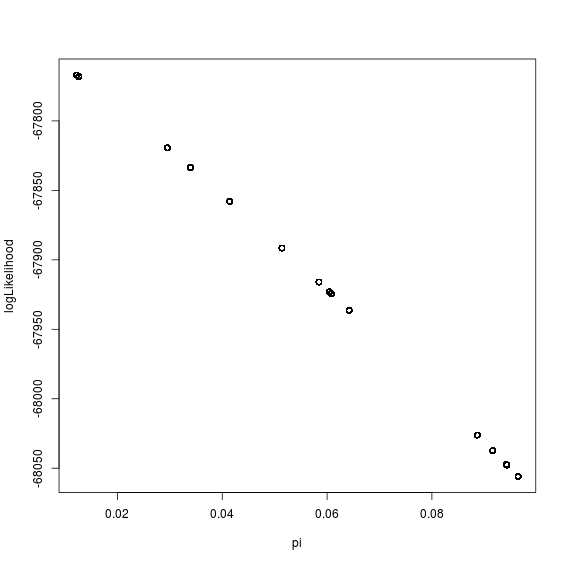

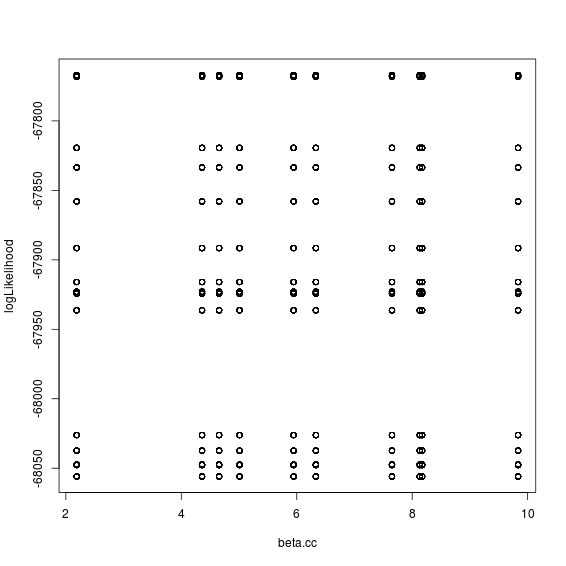

In [37]:
%%R -h 20 -w 20 -u cm

plot(c.cc.grid[, 1], -c.cc.grid[, 4], xlab = 'pi', ylab = 'logLikelihood')
plot(c.cc.grid[, 2], -c.cc.grid[, 4], xlab = 'gamma.mean.cc', ylab = 'logLikelihood')

plot(c.cc.grid[, 3], -c.cc.grid[, 4], xlab = 'beta.cc', ylab = 'logLikelihood')



